In [2]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import skopt

# Model

In [ ]:
torch.set_default_dtype(torch.float64)


class PINN(nn.Module):
    def __init__(self, in_features):
        hidden_size, num_hidden_layers, out_features = 40, 10, 1
        super(PINN, self).__init__()
        layers = [nn.Linear(in_features, hidden_size)]
        layers += [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers - 1)]
        layers.append(nn.Linear(hidden_size, out_features))
        self.layers = nn.ModuleList(layers)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        return x


class PINN(nn.Module):
    def __init__(self, in_features):
        hidden_size, num_hidden_layers, out_features = 40, 5, 1
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features, hidden_size))
        for _ in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, out_features))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x


# LOSS FUNCTION

In [ ]:

def pde_loss(u_pred, data):
    x = data[:, :-1]
    t = data[:, -1]
    u_pred.requires_grad_(True)

    grad_u_pred = torch.autograd.grad(u_pred, data, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True, only_inputs=True)[0]
    grad_u_pred_t = grad_u_pred[:, -1].unsqueeze(1)

    grad2_xi = 0

    for i in range(x.shape[1]):
        grad_x_i = grad_u_pred[:, i].unsqueeze(1)
        second_grad_x_i = torch.autograd.grad(grad_x_i, data, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True, only_inputs=True)[0][:, i].unsqueeze(1)
        grad2_xi += second_grad_x_i

    loss_pde = ( grad_u_pred_t - grad2_xi ).pow(2).mean()
    return loss_pde

# we can already compute the real value to subtract from the prediction
# this function is more to show the structure of the loss function
# after we precompute the real value, and is more efficient

def boundary_loss(u_pred, data):
    x = data[:, :-1]
    t = data[:, -1]
    d = x.shape[1]
    norm_x_squared = torch.sum(x**2, dim=1)
    loss_bc = (u_pred - (norm_x_squared/d) -( 2 * t)).pow(2).mean()
    return loss_bc


def initial_condition_loss(u, data):
    x = data[:, :-1]
    d = x.shape[1]

    norm_x_squared = torch.sum(x**2, dim=1)
    loss_init = (u - (norm_x_squared/d)).pow(2).mean()
    return loss_init

# Generate points

In [ ]:


def generare_poits(dimension, num_s=300, num_s_bc=30, epsilon=1e-60):

    num_samples = num_s * dimension
    num_samples_bc = num_s_bc*dimension

    space = [(epsilon, 1.0 - epsilon)] * dimension
    sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)

    x_domain = np.array(sampler.generate(space, num_samples))

    x_bc = []

    num_samples_per_face = num_samples_bc // (2*dimension)

    if dimension > 1:
        for i in range(dimension):
            for j in [0, 1]:
                pt_tmp = np.array(sampler.generate([(0., 1.)] * (dimension-1), num_samples_per_face))
                full_points = np.insert(pt_tmp, i, j, axis=1)
                x_bc.append(full_points)

    else:
        # if we have only 1 dimension we can have 2 poits on the boundary at the left and right
        x_bc.append(np.array([[0.], [1.]]))





    x_bc = np.concatenate(x_bc, axis=0)


    return x_domain, x_bc

# make test point not on the boundary
def test_points(dimension, point_per_dim=3):
    n_bins = point_per_dim * np.ones(dimension)
    bounds = np.repeat([(0.1, 0.9)], dimension, axis=0)
    result = np.mgrid[[slice(row[0], row[1], int(n)*1j) for row, n in zip(bounds, n_bins)]]
    result = result.reshape(dimension, -1).T
    return result


def test_points2(dimension, point_per_dim=5):
    n_bins = point_per_dim * np.ones(dimension)
    bounds = np.repeat([(0, 1)], dimension, axis=0)

    result = np.mgrid[[slice(row[0], row[1], int(n)*1j) for row, n in zip(bounds, n_bins)]]
    result = result.reshape(dimension, -1).T

    return result

def time_points(num_points, Time_interval=1.0, start_interval=0.0):
    # unifrom from 0 to Time_interval so ex 0, 0.2 0.4, 0.6, 0.8, 1.0
    unif_time = np.linspace(start_interval, Time_interval, num_points)
    return unif_time.reshape(-1, 1)

    return np.random.uniform(0, Time_interval, num_points).reshape(-1, 1)


def combine_space_time(x, t):
    x = np.repeat(x, t.shape[0], axis=0)
    t = np.tile(t, (x.shape[0] // t.shape[0], 1))
    return np.concatenate([x, t], axis=1)



# Visualization of Data in 2D + 1

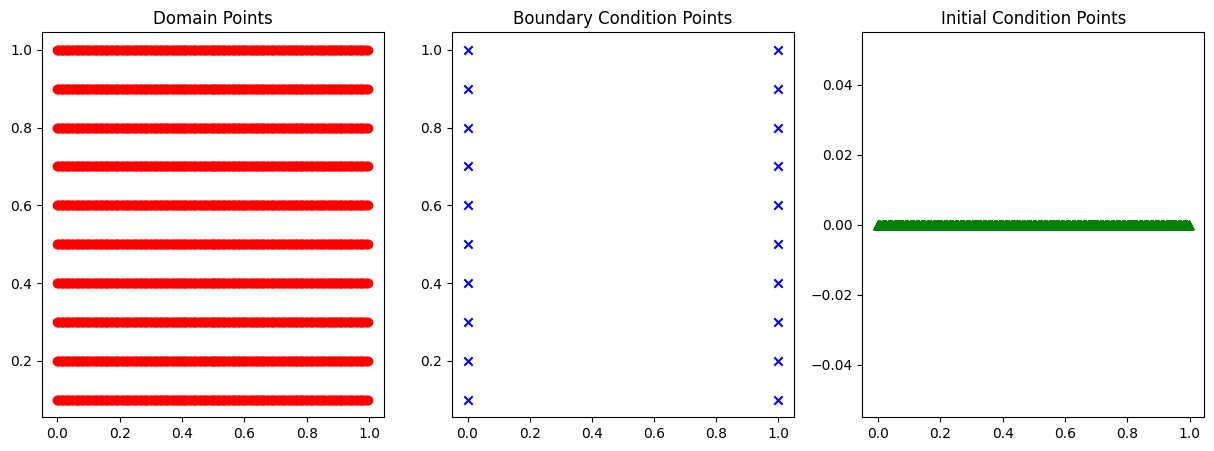

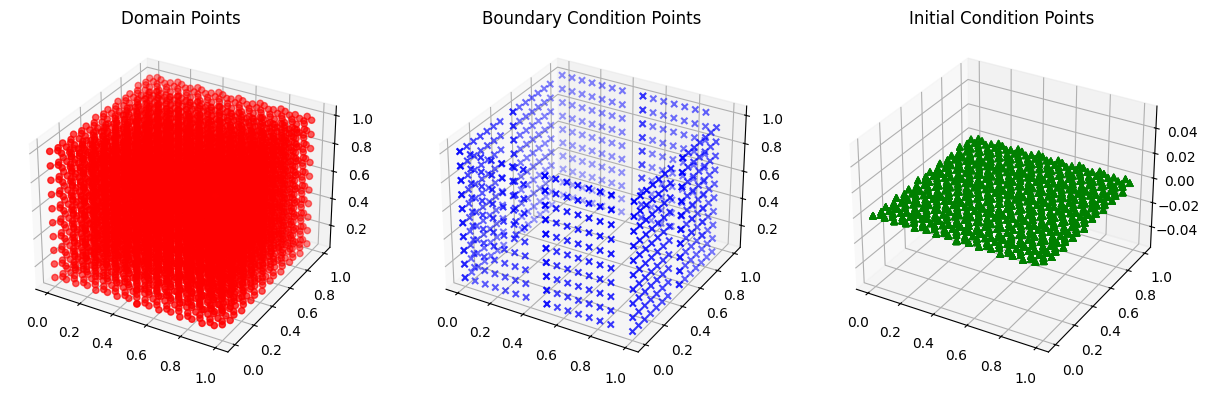

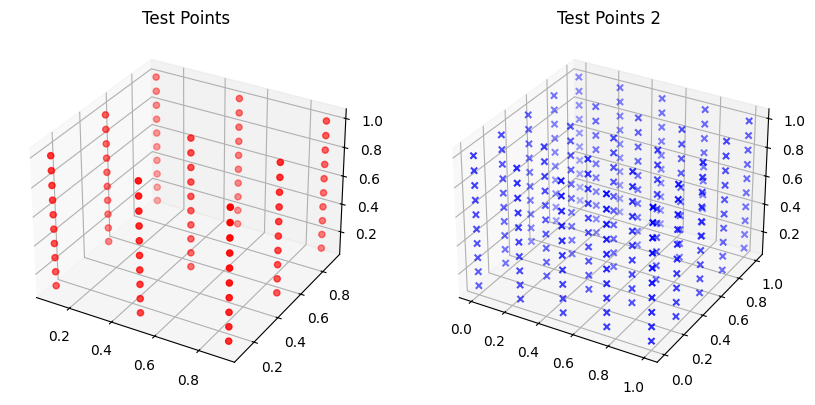

In [ ]:
dim = 1

# plot in 1 dimension spatial + 1 time

x_domain, x_bc = generare_poits(dim)
x_initial = x_domain.copy()
t_points = time_points(10, Time_interval=1.0)

# Combine spatial and temporal points
# make a copy of time without the time 0 for the domain points
t_points_2 = time_points(10, Time_interval=1.0, start_interval=0.1)
space_time_domain = combine_space_time(x_domain, t_points_2)
space_time_bc = combine_space_time(x_bc, t_points_2)
space_time_initial = combine_space_time(x_initial, np.zeros_like(t_points))

# plot data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(space_time_domain[:, 0], space_time_domain[:, 1], c='r', marker='o')
axs[0].set_title('Domain Points')
axs[1].scatter(space_time_bc[:, 0], space_time_bc[:, 1], c='b', marker='x')
axs[1].set_title('Boundary Condition Points')
axs[2].scatter(space_time_initial[:, 0], space_time_initial[:, 1], c='g', marker='^')
axs[2].set_title('Initial Condition Points')
plt.show()



dim = 2

# TRAINING POINTS

x_domain, x_bc = generare_poits(dim)
x_initial = x_domain.copy()
t_points = time_points(10, Time_interval=1.0)

# Combine spatial and temporal points
# make a copy of time without the time 0 for the domain points
t_points_2 = time_points(10, Time_interval=1.0, start_interval=0.1)
space_time_domain = combine_space_time(x_domain, t_points_2)
space_time_bc = combine_space_time(x_bc, t_points_2)
space_time_initial = combine_space_time(x_initial, np.zeros_like(t_points))


# Plotting just the spatial components to verify the distribution
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
axs[0].scatter(space_time_domain[:, 0], space_time_domain[:, 1], space_time_domain[:, 2], c='r', marker='o')
axs[0].set_title('Domain Points')
axs[1].scatter(space_time_bc[:, 0], space_time_bc[:, 1], space_time_bc[:, 2], c='b', marker='x')
axs[1].set_title('Boundary Condition Points')
axs[2].scatter(space_time_initial[:, 0], space_time_initial[:, 1], space_time_initial[:, 2], c='g', marker='^')
axs[2].set_title('Initial Condition Points')
plt.show()


# gereate test points
test_points_plt = test_points(dim)
test_points2_plt = test_points2(dim)

# Combine spatial and temporal points
t_points = time_points(10, Time_interval=1.0)

# make a copy of time without the time 0 for the domain points
t_points_2 = time_points(10, Time_interval=1.0, start_interval=0.1)
test_space_time = combine_space_time(test_points_plt, t_points_2)
test_space_time2 = combine_space_time(test_points2_plt, t_points_2)

# Plotting just the spatial components to verify the distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})
axs[0].scatter(test_space_time[:, 0], test_space_time[:, 1], test_space_time[:, 2], c='r', marker='o')
axs[0].set_title('Test Points')
axs[1].scatter(test_space_time2[:, 0], test_space_time2[:, 1], test_space_time2[:, 2], c='b', marker='x')
axs[1].set_title('Test Points 2')
plt.show()




In [ ]:

def analytical_u(data):
    x = data[:, :-1]
    t = data[:, -1]
    d = x.shape[1]
    return (torch.sum(x**2, dim=1)/d + 2*t).unsqueeze(1)

def initial_u_a(data):
    x = data[:, :-1]
    d = x.shape[1]
    return (torch.sum(x**2, dim=1)/d).unsqueeze(1)

# relative L2 error between the predicted and true solution
def compute_relative_l2_error(u_pred, u_true):
    error = torch.norm(u_pred - u_true)
    norm_true = torch.norm(u_true)
    return (error / norm_true).item()


# we know the boundary values and initial values
# we do u_pred - (||x||^2 / d - 2t)
#       u_pred - u_true for the boundary condition
def boundary_condition_loss( predicted, boundary_values):
    return torch.mean((predicted - boundary_values) ** 2)


# we do u_pred - (||x||^2 / d - 2t)
#       u_pred - u_true for the boundary condition
def initial_condition_loss( predicted, initial_values):
    return torch.mean((predicted - initial_values) ** 2)


dimesnions = [1,2,3,4,5,6,7,8,9,10]
dimesnions = [2]
# to speeduo only to see if work you can run only with dimesnions = [2] or any other number
errors_dim = []
for dim in dimesnions:


    # ####################
    # ## TRAINING POINTS #
    # ####################

    # STEP 1 : Generate the points for space and time
    x_domain, x_bc = generare_poits(dim)
    x_initial = x_domain.copy()

    # we generate t_points_2 because we don't want not t=0 in not initial points :)
    t_points = time_points(10, Time_interval=1.0)
    t_points_2 = time_points(10, Time_interval=1.0, start_interval=0.1)

    # STEP 2 : Combine spatial and temporal points
    space_time_domain = combine_space_time(x_domain, t_points_2)
    space_time_bc = combine_space_time(x_bc, t_points_2)
    space_time_initial = combine_space_time(x_initial, np.zeros_like(t_points))



    # ####################
    # #### TEST POINTS ###
    # ####################

    x_test = test_points(dim, point_per_dim=2)
    t_test = time_points(10, Time_interval=1.0)
    space_time_test = combine_space_time(x_test, t_test)



    # ###############################
    # #### PREPARE DATA FOR TORCH ###
    # ###############################

    space_time_bc = torch.tensor(space_time_bc, requires_grad=True)
    space_time_initial = torch.tensor(space_time_initial, requires_grad=True)
    space_time_test = torch.tensor(space_time_test, requires_grad=True)
    space_time_domain = torch.tensor(space_time_domain, dtype=torch.float64, requires_grad=True)


    u_exact_test = analytical_u(space_time_test)
    u_exact_test = analytical_u(space_time_test)
    boundary_values = analytical_u(space_time_bc)
    initial_values = initial_u_a(space_time_initial)



    # ###############################
    # #### TRAINING THE NETWORK #####
    # ###############################

    model = PINN(dim+1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    num_epochs = 1000
    errors = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()


        u_pred = model(space_time_domain)
        u_pred_bc = model(space_time_bc)
        u_pred_initial = model(space_time_initial)

        pde_loss_value = pde_loss(u_pred, space_time_domain)
        boundary_loss_value = boundary_condition_loss(u_pred_bc, boundary_values)
        initial_loss_value = initial_condition_loss(u_pred_initial, initial_values)

        total_loss = 0.5 * pde_loss_value + boundary_loss_value + initial_loss_value

        total_loss.backward(retain_graph=True)

        optimizer.step()

        with torch.no_grad():
            u_pred_test = model(space_time_test)
            error = compute_relative_l2_error(u_pred_test, u_exact_test)
            errors.append(error)

        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch}, Loss {total_loss.item()}')
        #     print(f'Error {error}')

    print("#################################")
    print(f'Error for dimension {dim} is {errors[-1]}')
    errors_dim.append(errors)






#################################
Error for dimension 2 is 0.007046592572390635


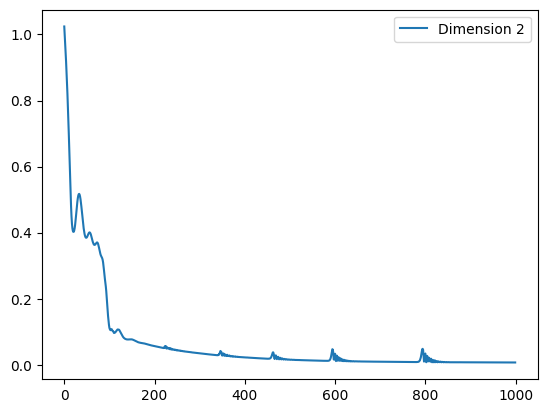

In [ ]:
# plot the errors for each dimension
fig, ax = plt.subplots()
for i, error in enumerate(errors_dim):
    ax.plot(error, label=f'Dimension {dimesnions[i]}')
ax.legend()
plt.show()

In [ ]:
# print  the final errors for each dimension
for i, error in enumerate(errors_dim):
    print(f'Error for dimension {dimesnions[i]} is {error[-1]}')


Error for dimension 2 is 0.007078516466206156


#################################
Error for dimension 2 is 0.0059839854625565675


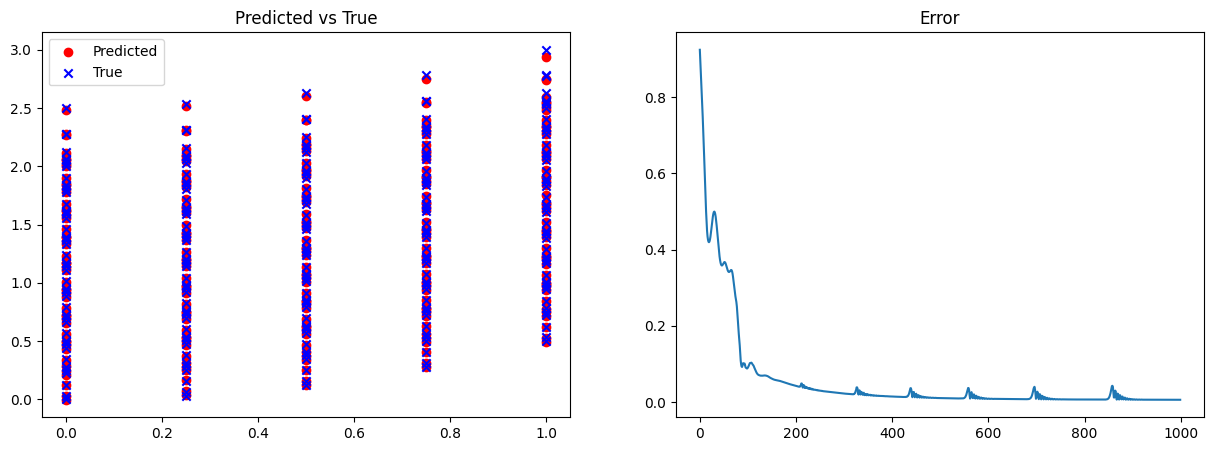

In [ ]:

def analytical_u(data):
    x = data[:, :-1]
    t = data[:, -1]
    d = x.shape[1]
    return (torch.sum(x**2, dim=1)/d + 2*t).unsqueeze(1)

def initial_u_a(data):
    x = data[:, :-1]
    d = x.shape[1]
    return (torch.sum(x**2, dim=1)/d).unsqueeze(1)

# relative L2 error between the predicted and true solution
def compute_relative_l2_error(u_pred, u_true):
    error = torch.norm(u_pred - u_true)
    norm_true = torch.norm(u_true)
    return (error / norm_true).item()


# we know the boundary values and initial values
# we do u_pred - (||x||^2 / d - 2t)
#       u_pred - u_true for the boundary condition
def boundary_condition_loss( predicted, boundary_values):
    return torch.mean((predicted - boundary_values) ** 2)


# we do u_pred - (||x||^2 / d - 2t)
#       u_pred - u_true for the boundary condition
def initial_condition_loss( predicted, initial_values):
    return torch.mean((predicted - initial_values) ** 2)

dimesnions = [2]
errors_dim = []
for dim in dimesnions:


    # ####################
    # ## TRAINING POINTS #
    # ####################

    # STEP 1 : Generate the points for space and time
    x_domain, x_bc = generare_poits(dim)
    x_initial = x_domain.copy()

    # we generate t_points_2 because we don't want not t=0 in not initial points :)
    t_points = time_points(10, Time_interval=1.0)
    t_points_2 = time_points(10, Time_interval=1.0, start_interval=0.1)

    # STEP 2 : Combine spatial and temporal points
    space_time_domain = combine_space_time(x_domain, t_points_2)
    space_time_bc = combine_space_time(x_bc, t_points_2)
    space_time_initial = combine_space_time(x_initial, np.zeros_like(t_points))



    # ####################
    # #### TEST POINTS ###
    # ####################

    x_test = test_points2(dim, point_per_dim=5)
    t_test = time_points(10, Time_interval=1.0)
    space_time_test = combine_space_time(x_test, t_test)



    # ###############################
    # #### PREPARE DATA FOR TORCH ###
    # ###############################

    space_time_bc = torch.tensor(space_time_bc, requires_grad=True)
    space_time_initial = torch.tensor(space_time_initial, requires_grad=True)
    space_time_test = torch.tensor(space_time_test, requires_grad=True)
    space_time_domain = torch.tensor(space_time_domain, dtype=torch.float64, requires_grad=True)


    u_exact_test = analytical_u(space_time_test)
    u_exact_test = analytical_u(space_time_test)
    boundary_values = analytical_u(space_time_bc)
    initial_values = initial_u_a(space_time_initial)



    # ###############################
    # #### TRAINING THE NETWORK #####
    # ###############################

    model = PINN(dim+1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    num_epochs = 1000
    errors = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()


        u_pred = model(space_time_domain)
        u_pred_bc = model(space_time_bc)
        u_pred_initial = model(space_time_initial)

        pde_loss_value = pde_loss(u_pred, space_time_domain)
        boundary_loss_value = boundary_condition_loss(u_pred_bc, boundary_values)
        initial_loss_value = initial_condition_loss(u_pred_initial, initial_values)

        total_loss = 0.5 * pde_loss_value + boundary_loss_value + initial_loss_value

        total_loss.backward(retain_graph=True)

        optimizer.step()

        with torch.no_grad():
            u_pred_test = model(space_time_test)
            error = compute_relative_l2_error(u_pred_test, u_exact_test)
            errors.append(error)

        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch}, Loss {total_loss.item()}')
        #     print(f'Error {error}')

    print("#################################")
    print(f'Error for dimension {dim} is {errors[-1]}')
    errors_dim.append(errors)

    if dim == 2:
        # diplay the prediction vs the real value
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].scatter(space_time_test[:, 0].detach().numpy(), u_pred_test.detach().numpy(), c='r', marker='o', label='Predicted')
        axs[0].scatter(space_time_test[:, 0].detach().numpy(), u_exact_test.detach().numpy(), c='b', marker='x', label='True')
        axs[0].set_title('Predicted vs True')
        axs[0].legend()
        axs[1].plot(errors)
        axs[1].set_title('Error')
        plt.show()




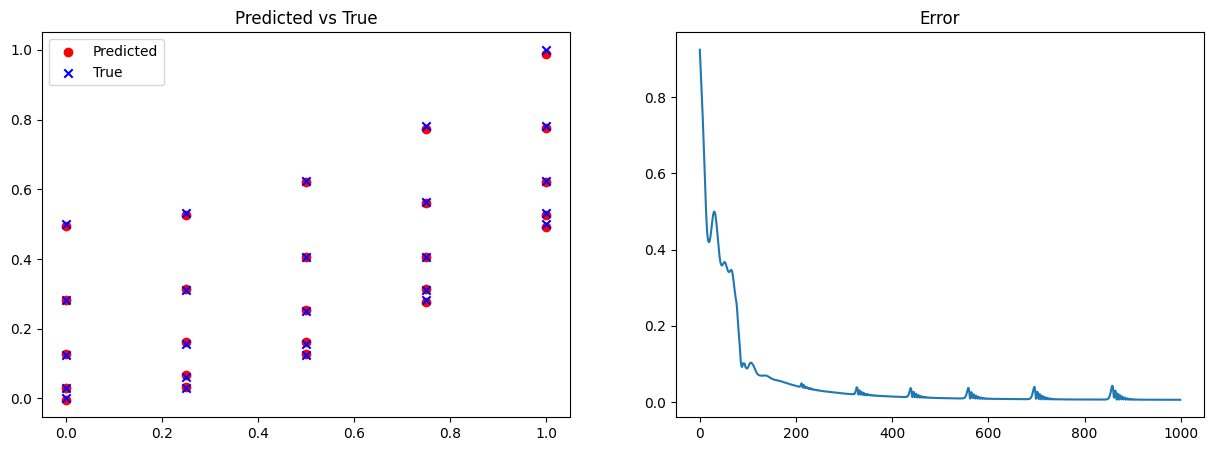

In [ ]:
# dim = 2
# display only 10 % of test points
# plot the prediction vs the real value
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(space_time_test[::10, 0].detach().numpy(), u_pred_test[::10].detach().numpy(), c='r', marker='o', label='Predicted')
axs[0].scatter(space_time_test[::10, 0].detach().numpy(), u_exact_test[::10].detach().numpy(), c='b', marker='x', label='True')
axs[0].set_title('Predicted vs True')
axs[0].legend()
axs[1].plot(errors)
axs[1].set_title('Error')
plt.show()






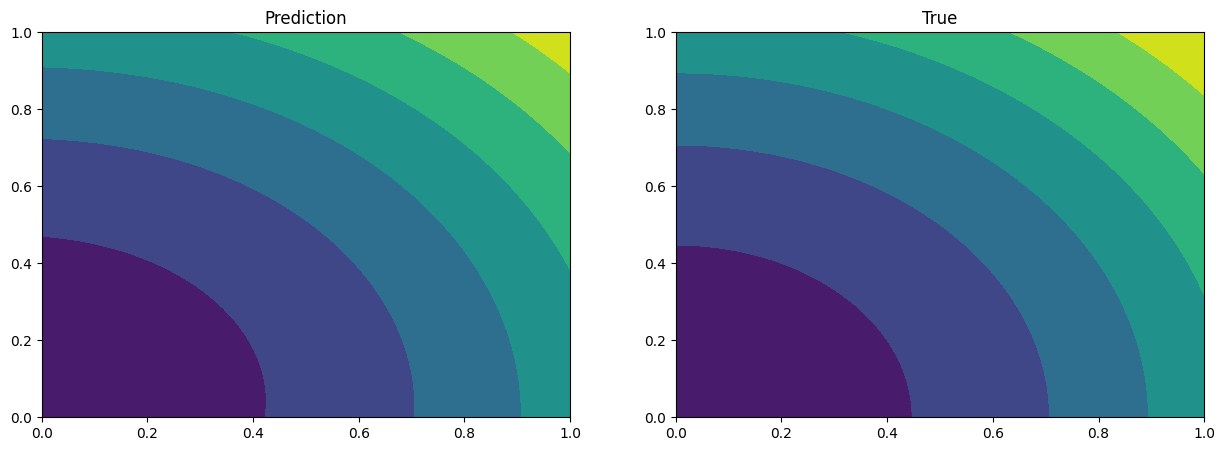

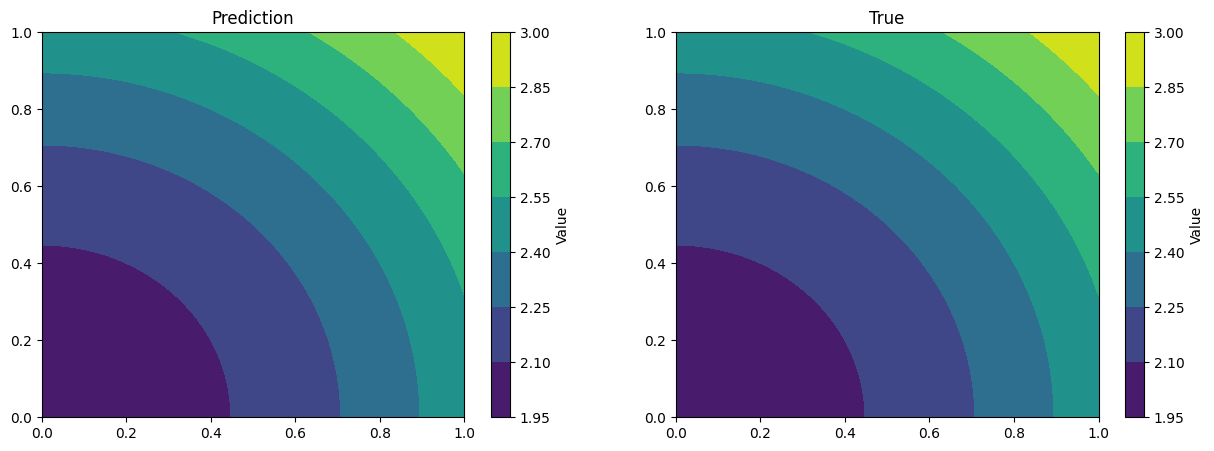

In [ ]:
# make a Contour plot for the 2D case
# we will plot the prediction and the real value


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = model(torch.tensor([[X[i, j], Y[i, j], 1]], dtype=torch.float64)).item()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].contourf(X, Y, Z, cmap='viridis')
axs[0].set_title('Prediction')
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = analytical_u(torch.tensor([[X[i, j], Y[i, j], 1]], dtype=torch.float64)).item()

axs[1].contourf(X, Y, Z, cmap='viridis')
axs[1].set_title('True')

plt.show()

# plot with legend of values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
c = axs[0].contourf(X, Y, Z, cmap='viridis')
axs[0].set_title('Prediction')
fig.colorbar(c, ax=axs[0], label='Value')
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = analytical_u(torch.tensor([[X[i, j], Y[i, j], 1]], dtype=torch.float64)).item()

c = axs[1].contourf(X, Y, Z, cmap='viridis')
axs[1].set_title('True')
fig.colorbar(c, ax=axs[1], label='Value')
plt.show()




